<a href="https://colab.research.google.com/github/cnielly/prototypical-networks-omniglot/blob/master/prototypical_networks_pytorch_omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models 

In [2]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

False


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip --qq /content/drive/MyDrive/Advanced_Vision/train_resized.zip -d /content/

In [2]:
import os

path_ = "./data/train_resized"
train_folder = os.listdir(path_) 
categories = [i for i in train_folder if os.path.isdir(os.path.join(path_,i))]
len(categories)

1000

In [3]:
category_dict = dict([(y,x) for x,y in enumerate(sorted(set(categories)))])
len(category_dict)

1000

In [4]:
# category_dict.values()
# test_path = "/content/test"

In [5]:
import math
import concurrent.futures
import tqdm as tqdm
import numpy as np
import cv2

train_address = "./data/train_resized"
def scantree(path):
    """Recursively yield DirEntry objects for given directory."""
    for entry in os.scandir(path):
        if (entry.name not in ["augmented_middle_training"]) & (entry.is_dir(follow_symlinks=False)):
            yield from scantree(entry.path)
        else:
            yield entry

def f(path):
    return cv2.resize(cv2.imread(path),(224,224))
    # return cv2.imread(path)


def l(path):
    for word in path.split("/"):
        if word in category_dict:
            return category_dict[word]
        
extnsn_list = ['jpg', 'JPG', 'png', 'PNG', 'bmp', 'BMP', 'jpeg', 'JPEG']
# files_test = []
# files_test+=list(map(lambda x:x.path,list(scantree(test_address))))

files_train = []
files_train+=list(map(lambda x:x.path,list(scantree(train_address))))

files_train = list(filter(lambda x: x.split('.')[-1] in extnsn_list ,tqdm.tqdm(files_train,desc="Filtering files...")))
# files_test = list(filter(lambda x: x.split('.')[-1] in extnsn_list ,tqdm.tqdm(files_test,desc="Filtering files...")))

with concurrent.futures.ThreadPoolExecutor(max_workers=25) as executor:
    # test_X = np.array(list(tqdm.tqdm(executor.map(lambda image: f(image), files_test),desc="Loading val files...", total=len(files_test)))) 
    train_X=np.array(list(tqdm.tqdm(executor.map(lambda image: f(image), files_train),desc="Loading train files...", total=len(files_train))))
    train_y = np.array(list(tqdm.tqdm(executor.map(lambda image: l(image), files_train),desc="Loading train files...", total=len(files_train))))
    # test_y = np.array(list(tqdm.tqdm(executor.map(lambda image: l(image), files_test),desc="Loading val files...", total=len(files_test))))
    executor.shutdown()
    
print(train_X.shape)
print(train_y.shape)
# print(test_X.shape)
# print(test_y.shape)

Loading train files...: 100%|█████████| 50000/50000 [00:00<00:00, 387778.38it/s]

(50000, 28, 28, 3)
(50000,)


In [8]:
# test_y = np.loadtxt("/content/drive/MyDrive/Advanced_Vision/ILSVRC2012_test_ground_truth.txt").astype(int)
# test_y

In [7]:
len(np.unique(train_y))

1000

In [9]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    
    """
    Picks random sample of size n_support+n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    # print(K)
    for cls in K:
        # print(cls)
        # print(np.unique(datay == cls, return_counts = True))
        datax_cls = datax[datay == cls]
        # print(datax_cls.shape)
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support+n_query)]
        sample.append(sample_cls)
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0,1,4,2,3)
    return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [11]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


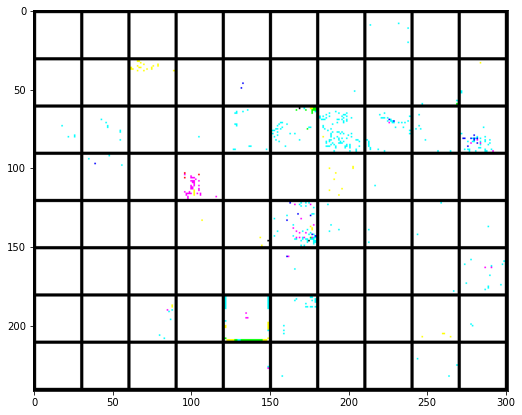

In [12]:
sample_example = extract_sample(8, 5, 5, train_X, train_y)
display_sample(sample_example['images'])

In [13]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    model_r50 = models.resnet50(pretrained = False)
    encoder = nn.Sequential(*list(model_r50.children())[:-1], Flatten())


    return ProtoNet(encoder)

In [17]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        # self.encoder = encoder.cuda()
        self.encoder = encoder

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat
        """
        sample_images = sample['images'] # .cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        #target indices are 0 ... n_way-1
        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds # .cuda()

        #encode images of the support and the query set
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                       x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)

        z = self.encoder.forward(x)
        z_dim = z.size(-1) #usually 64
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        #compute distances
        dists = euclidean_dist(z_query, z_proto)

        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
            }

In [18]:
def euclidean_dist(x, y):
    """
    Computes euclidean distance btw x and y
    Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
    Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
    """
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

##Train

In [21]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [22]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far
    stop = False #status to know when to stop

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
          # if episode % 100 == 0:
            # print("{} episode going on...".format(episode))
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        PATH = '/afs/inf.ed.ac.uk/user/s22/s2233836/AV/ModelWeights_3March/weights_' + str(epoch) + '.pth'
        torch.save(model.state_dict(), PATH)
        epoch += 1
        scheduler.step()

In [ ]:
%%time

model = load_protonet_conv()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = train_X
train_y = train_y

max_epoch = 5
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

/tmp/ipykernel_914965/2343309530.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

##Test

In [ ]:
PATH = "/content/drive/MyDrive/Advanced_Vision/model_trial24feb.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
n_way = 5
n_support = 5
n_query = 5

test_x = test_X
test_y = test_y

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app


  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 2.6904 Acc: 0.2012


In [ ]:
# !unzip --qq /content/drive/MyDrive/Advanced_Vision/test.zip -d /content/